# 1. 라이브러리 호출

In [1]:
import random
import math
from datetime import datetime

import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from statsmodels.stats.power import TTestIndPower, tt_ind_solve_power

from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.proportion import proportions_chisquare, confint_proportions_2indep

# Disable warnings
from warnings import filterwarnings


# Set seed for np random
SEED = 123
np.random.seed(SEED)
filterwarnings('ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'

# 2. 데이터 로드

In [2]:
data_path = 'Data/'
pretest = pd.read_csv(data_path + 'pretest.csv');print('Pretest Data Imported!')
test = pd.read_csv(data_path + 'test.csv'); print('Test Data Imported!')

# Set date fields as date_time
pretest['date'] = pd.to_datetime(pretest['date'])
test['date'] = pd.to_datetime(test['date'])

Pretest Data Imported!
Test Data Imported!


# 3. EDA

In [3]:
# Display the first five rows of the pretest table
pretest.head()

,visitor_id,date,email,experiment,group,submitted
0,1,2021-12-01,NaN,NaN,NaN,0
1,2,2021-12-01,NaN,NaN,NaN,0
2,3,2021-12-01,NaN,NaN,NaN,0
3,4,2021-12-01,NaN,NaN,NaN,0
4,5,2021-12-01,NaN,NaN,NaN,0


In [4]:
print('rows count:', pretest.shape[0])
print('Date range:', pretest.date.min(), '-', pretest.date.max())

rows count: 309903
Date range: 2021-12-01 00:00:00 - 2021-12-31 00:00:00


In [5]:
pretest.isnull().mean()

visitor_id    0.000000
date          0.000000
email         0.899017
experiment    0.903070
group         0.903070
submitted     0.000000
dtype: float64

In [6]:
# 총 방문 고객
print('Total visitor count:', pretest.visitor_id.nunique())
# 이메일 등록 고객
print('Sign-up count:', pretest.submitted.sum())
# 이메일 등록 비율
print('Sign-up rate:', pretest.submitted.mean().round(2))

Total visitor count: 309903
Sign-up count: 31295
Sign-up rate: 0.1


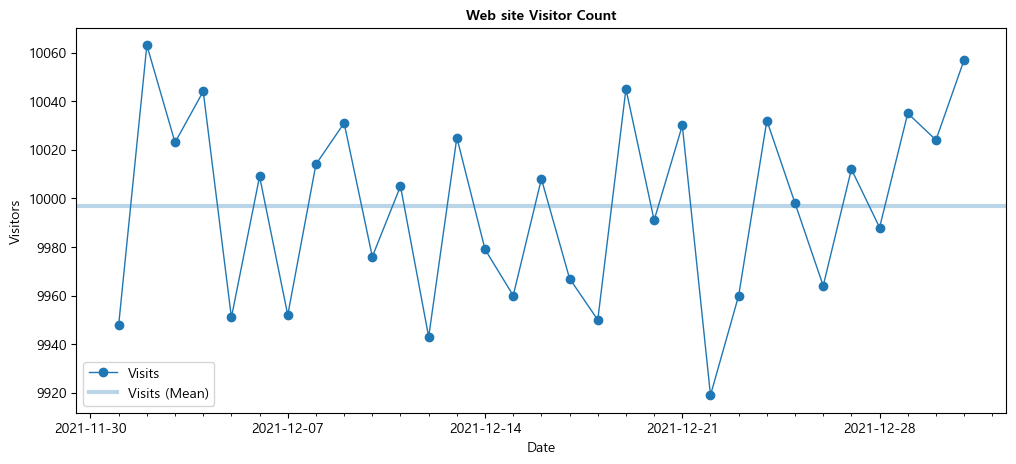

In [7]:
# Set the color palette for the plot
colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

# Count sign-ups by date
visits_per_day = pretest.groupby('date')['submitted'].count()
visits_mean = visits_per_day.mean()

# Plot data
f, ax = plt.subplots(figsize=(12, 5))
plt.plot(visits_per_day.index, visits_per_day, '-o', color=c1, linewidth=1, label='Visits')
plt.axhline(visits_mean, color=c1, linestyle='-', linewidth=3, alpha=0.3, label='Visits (Mean)')

# Format plot
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator())
plt.title('Web site Visitor Count', fontsize=10, weight='bold')
plt.ylabel('Visitors', fontsize=10)
plt.xlabel('Date', fontsize=10)
plt.legend()

plt.show()

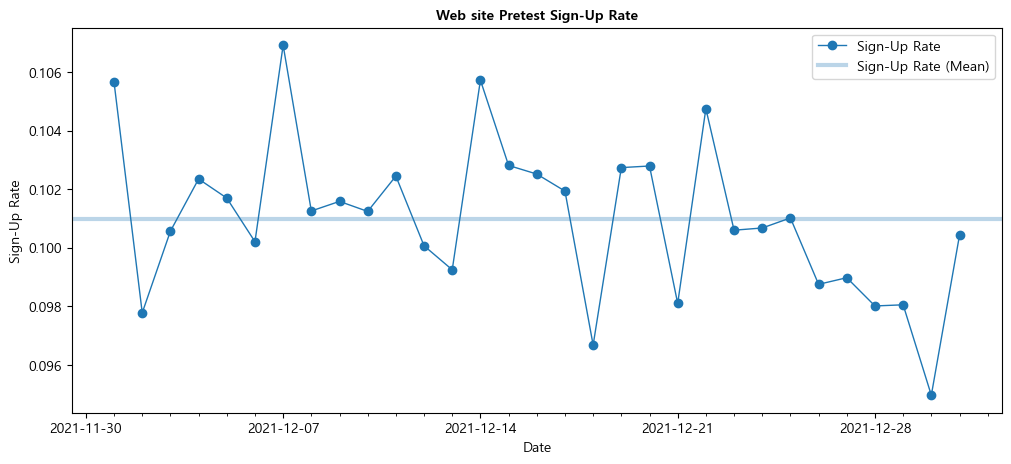

In [8]:
# Get the submission rate per date
signup_rate_per_day = pretest.groupby('date')['submitted'].mean() 
signup_rate_mean = signup_rate_per_day.mean() 

# Plot data
f, ax = plt.subplots(figsize=(12, 5))
plt.plot(signup_rate_per_day.index, signup_rate_per_day, '-o', color=c1, linewidth=1, label='Sign-Up Rate')
plt.axhline(signup_rate_mean, color=c1, linestyle='-', linewidth=3, alpha=0.3, label='Sign-Up Rate (Mean)')

# Format plot
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator())
plt.title('Web site Pretest Sign-Up Rate', fontsize=10, weight='bold')
plt.ylabel('Sign-Up Rate', fontsize=10)
plt.xlabel('Date', fontsize=10)
plt.legend()
plt.show()

# 4. 가설 설정

In [9]:
# 유의수준
alpha = 0.05
# 검정력
power = 0.80
# MDE
mde = 0.10

p1 = 0.10
p2 = p1 * (1+p1)

# 5. 표본 사이즈 설정

To detect an effect of 10.0% lift from the pretest sign-up at 10%, the sample size per group required is 15000.
The total sample required in the experiment is 30000.


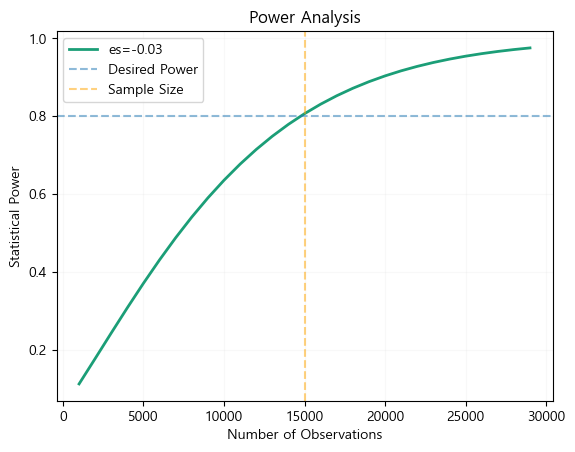

In [10]:
# Calculate the effect size using Cohen's D
cohen_D = sm.stats.proportion_effectsize(p1, p2)

# Estimate the sample size required per group
n = tt_ind_solve_power(effect_size=cohen_D, power=power, alpha=alpha)
n = int(round(n, -3)) # Round up to the nearest thousand

print(f'To detect an effect of {100*(p2/p1-1):.1f}% lift from the pretest sign-up at {100*p1:.0f}%, '
      f'the sample size per group required is {n}.'
      f'\nThe total sample required in the experiment is {2*n}.')

# Explore power across sample sizes
ttest_power = TTestIndPower()
ttest_power.plot_power(dep_var='nobs', nobs=np.arange(1000,30000,1000), effect_size=[cohen_D], title='Power Analysis')

# Set plot parameters
plt.axhline(0.8, linestyle='--', label='Desired Power', alpha=0.5)
plt.axvline(n, linestyle='--', color='orange', label='Sample Size', alpha=0.5)
plt.ylabel('Statistical Power')
plt.grid(alpha=0.08)
plt.legend()
plt.show()

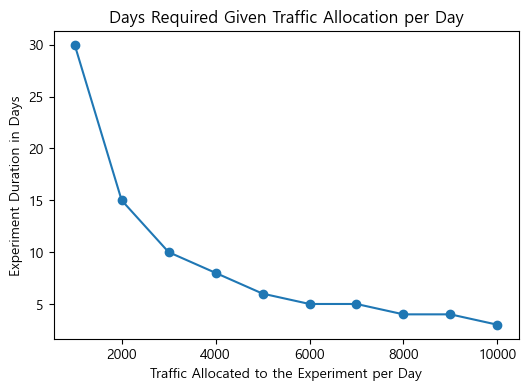

In [11]:
alloc = np.arange(0.10, 1.1, 0.1)
size = round(visits_mean, -3) * alloc
days = np.ceil(2*n / size)

f, ax = plt.subplots(figsize=(6, 4))
ax.plot(size, days, '-o')
# ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.set_title('Days Required Given Traffic Allocation per Day')
ax.set_ylabel('Experiment Duration in Days')
ax.set_xlabel('Traffic Allocated to the Experiment per Day')
plt.show()

In [12]:
# 실험기간에 따른 표본개수
print(f'실험기간이 21일 인 경우, {np.ceil(n * 2 / 21)} 명의 표본이 필요') 
print(f'실험기간이 14일 인 경우, {np.ceil(n * 2 / 14)} 명의 표본이 필요') 
print(f'실험기간이 7일 인 경우, {np.ceil(n * 2 / 7)} 명의 표본이 필요')   

실험기간이 21일 인 경우, 1429.0 명의 표본이 필요
실험기간이 14일 인 경우, 2143.0 명의 표본이 필요
실험기간이 7일 인 경우, 4286.0 명의 표본이 필요


In [13]:
AB_test = test.query("experiment == 'email_test'")
control_signups = AB_test.query("group == 0")['submitted']
treatment_signups = AB_test[AB_test.group == 1]['submitted']

# Get stats 
AB_control_cnt = control_signups.sum()          # Control Sign-Up Count
AB_treatment_cnt = treatment_signups.sum()
AB_control_rate = control_signups.mean()        # Control Sign-Up Rate
AB_treatment_rate = treatment_signups.mean()
AB_control_size = control_signups.count()       # Control Sample Size 
AB_treatment_size = treatment_signups.count() 

# Show calculation
print(f'대조군 이메일 등록 비율: {AB_control_rate:.4}')
print(f'실험군 이메일 등록 비율: {AB_treatment_rate:.4}')

대조군 이메일 등록 비율: 0.09557
실험군 이메일 등록 비율: 0.1078


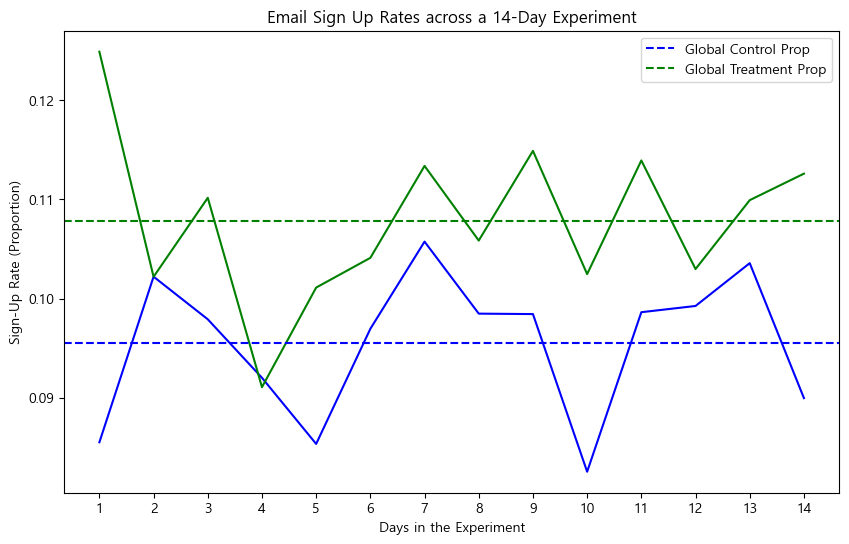

In [14]:
# 일 별 이메일 등록 비율 계산
signups_per_day = AB_test.groupby(['group','date'], as_index=False)['submitted'].mean()
ctrl_props = signups_per_day.query('group == 0')['submitted']
trt_props = signups_per_day.query('group == 1')['submitted']

exp_days = range(1, AB_test['date'].nunique() + 1)

f, ax = plt.subplots(figsize=(10, 6))

ax.plot(exp_days, ctrl_props, color='b')
ax.plot(exp_days, trt_props, color='g')
ax.axhline(AB_control_rate, label='Global Control Prop', linestyle='--', color='b')
ax.axhline(AB_treatment_rate, label='Global Treatment Prop', linestyle='--', color='g')

# # Format plot
ax.set_xticks(exp_days)
ax.set_title('Email Sign Up Rates across a 14-Day Experiment')
ax.set_ylabel('Sign-Up Rate (Proportion)')
ax.set_xlabel('Days in the Experiment')
ax.legend()
plt.show()

In [15]:
# AA테스트 진행

AA_test = pretest[pretest.experiment == 'AA_test']

# 실험군과 대조군 추출
AA_control = AA_test[AA_test.group == 0]['submitted']
AA_treatment = AA_test[AA_test.group == 1]['submitted']

# 실험군과 대조군 결과값 산출
AA_control_cnt = AA_control.sum()
AA_treatment_cnt = AA_treatment.sum()
AA_control_rate = AA_control.mean()
AA_treatment_rate = AA_treatment.mean()
AA_control_size = AA_control.count()
AA_treatment_size = AA_treatment.count()

# Show calculation
print('-------- AA Test ----------')
print(f'실험군 이메일 등록 비율: {AA_control_rate:.3}')
print(f'대조군 이메일 등록 비율: {AA_treatment_rate:.3}')

-------- AA Test ----------
실험군 이메일 등록 비율: 0.101
대조군 이메일 등록 비율: 0.0988


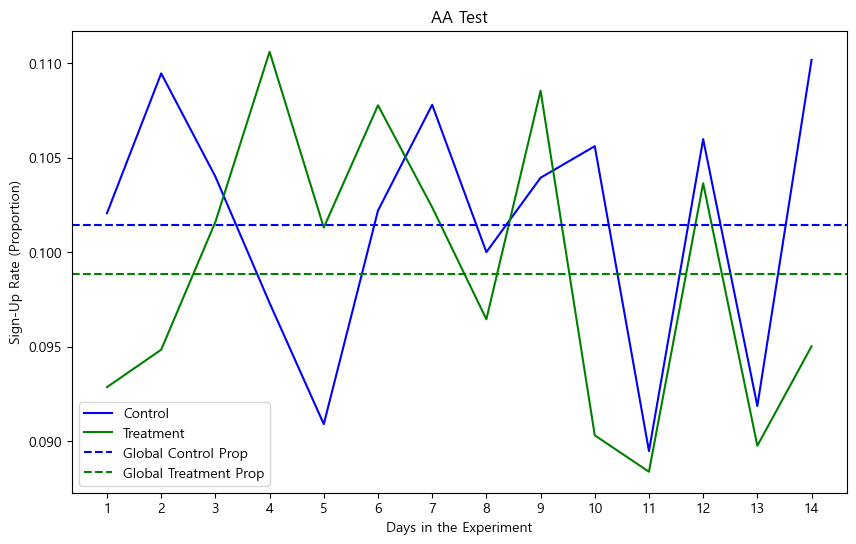

In [16]:
# 일 별 이메일 등록 비율 산출
AA_signups_per_day = AA_test.groupby(['group','date'])['submitted'].mean()
AA_ctrl_props = AA_signups_per_day.loc[0]
AA_trt_props = AA_signups_per_day.loc[1]

# AA테스트 기간 설정
exp_days = range(1, AA_test['date'].nunique() + 1)

f, ax = plt.subplots(figsize=(10, 6))
ax.plot(exp_days, AA_ctrl_props, label='Control', color='b')
ax.plot(exp_days, AA_trt_props, label='Treatment', color='g')
ax.axhline(AA_control_rate, label='Global Control Prop', linestyle='--', color='b')
ax.axhline(AA_treatment_rate, label='Global Treatment Prop', linestyle='--', color='g')

ax.set_xticks(exp_days)
ax.set_title('AA Test')
ax.set_ylabel('Sign-Up Rate (Proportion)')
ax.set_xlabel('Days in the Experiment')
ax.legend()
plt.show()

In [61]:
# 카이제곱 검정 진행

AA_chistats, AA_pvalue, AA_tab = proportions_chisquare([AA_control_cnt, AA_treatment_cnt], nobs=[AA_control_size, AA_treatment_size])

# 날짜 추출
first_date = AA_test['date'].min().date()
last_date = AA_test['date'].max().date()

# 유의수준 설정
AA_ALPHA = 0.05

print(f'-------- AA Test ({first_date} - {last_date})---------\n')
print('Ho: 버튼색이 파랑색인 경우와 초록색인 경우 이메일 등록 비율은 똑같다.')
print('Ha: 버튼색이 파랑색인 경우와 초록색인 경우 이메일 등록 비율은 다르다.\n')
print(f'유의수준: {AA_ALPHA}')

print(f'Chi-Square = {AA_chistats:.3f} | P-value = {AA_pvalue:.3f}')

print('\n결론:')
if AA_pvalue < AA_ALPHA:
  print('귀무가설을 기각한다.')
else:
  print('귀무가설을 채택한다.')

-------- AA Test (2021-12-18 - 2021-12-31)---------

Ho: 버튼색이 파랑색인 경우와 초록색인 경우 이메일 등록 비율은 똑같다.
Ha: 버튼색이 파랑색인 경우와 초록색인 경우 이메일 등록 비율은 다르다.

유의수준: 0.05
Chi-Square = 0.577 | P-value = 0.448

결론:
귀무가설을 채택한다.


In [68]:
# 표본 비율 불일치 테스트 진행

# 유의수준
SRM_ALPHA = 0.05

email_test = test[test.experiment == 'email_test']
observed = email_test.groupby('group')['experiment'].count().values
expected = [email_test.shape[0]*0.5]*2

chi_stats, pvalue = stats.chisquare(f_obs=observed, f_exp=expected)

print('------- A Chi-Square Test for SRM --------\n')
print('Ho: 표본의 비율은 1:1 이다.')
print('Ha: 표본의 비율은 1:1 이 아니다.\n')
print(f'유의수준: {SRM_ALPHA}')

print(f'Chi-Square = {chi_stats:.3f} | P-value = {pvalue:.3f}')

print('\n결론:')
if pvalue < SRM_ALPHA:
  print('귀무가설을 기간한다. 표본 비율 불일치가 존재한다.')
else:
  print('귀무가설을 채택한다. 두 그룹의 표본 비율은 동일하다.')

------- A Chi-Square Test for SRM --------

Ho: 표본의 비율은 1:1 이다.
Ha: 표본의 비율은 1:1 이 아니다.

유의수준: 0.05
Chi-Square = 1.290 | P-value = 0.256

결론:
귀무가설을 채택한다. 두 그룹의 표본 비율은 동일하다.


In [69]:
# AB테스트 유의수준 설정
AB_ALPHA = 0.05

In [70]:
# 카이제곱 검정 진행

# Execute test
AB_chistats, AB_pvalue, AB_tab = proportions_chisquare([AB_control_cnt, AB_treatment_cnt], nobs=[AB_control_size, AB_treatment_size])

# Grab dates
first_date = AB_test['date'].min().date()
last_date = AB_test['date'].max().date()

# Run results
print(f'-------- AB Test Email Sign-Ups ({first_date} - {last_date})---------\n')
print('Ho: 버튼색이 파랑색일 때와 초록색일 때는 이메일 등록 비율이 동일하다.')
print('Ha: 버튼색이 파랑색일 때와 초록색일 때는 이메일 등록 비율이 다른다.\n')
print(f'Significance level: {AB_ALPHA}')

print(f'Chi-Square = {AB_chistats:.3f} | P-value = {AB_pvalue:.3f}')

print('\n결론:')
if AB_pvalue < AB_ALPHA:
  print('귀무가설을 기각하고 두 그룹 간에는 유의미한 차이가 있다.')
else:
  print('귀무가설을 채택한다.')

-------- AB Test Email Sign-Ups (2022-02-01 - 2022-02-14)---------

Ho: 버튼색이 파랑색일 때와 초록색일 때는 이메일 등록 비율이 동일하다.
Ha: 버튼색이 파랑색일 때와 초록색일 때는 이메일 등록 비율이 다른다.

Significance level: 0.05
Chi-Square = 12.312 | P-value = 0.000

결론:
귀무가설을 기각하고 두 그룹 간에는 유의미한 차이가 있다.


In [71]:
# t테스트 진행

AB_tstat, AB_pvalue, AB_df = ttest_ind(treatment_signups, control_signups)

# 날짜 추출
first_date = AB_test['date'].min().date()
last_date = AB_test['date'].max().date()

# 결과
print(f'-------- AB Test Email Sign-Ups ({first_date} - {last_date})---------\n')
print('Ho: 버튼색이 파랑색일 때와 초록색일 때는 이메일 등록 비율이 동일하다.')
print('Ha: 버튼색이 파랑색일 때와 초록색일 때는 이메일 등록 비율이 다른다.\n')
print(f'Significance level: {AB_ALPHA}')

print(f'T-Statistic = {AB_tstat:.3f} | P-value = {AB_pvalue:.3f}')

print('\n결론:')
if AB_pvalue < AB_ALPHA:
  print('귀무가설을 기각하고 두 그룹 간에는 유의미한 차이가 있다.')
else:
  print('귀무가설을 채택한다.')

-------- AB Test Email Sign-Ups (2022-02-01 - 2022-02-14)---------

Ho: 버튼색이 파랑색일 때와 초록색일 때는 이메일 등록 비율이 동일하다.
Ha: 버튼색이 파랑색일 때와 초록색일 때는 이메일 등록 비율이 다른다.

Significance level: 0.05
T-Statistic = 3.509 | P-value = 0.000

결론:
귀무가설을 기각하고 두 그룹 간에는 유의미한 차이가 있다.


In [72]:
# Compute the Confidence Interval of the Test
ci = confint_proportions_2indep(AB_treatment_cnt, AB_treatment_size, AB_control_cnt, AB_control_size, method=None, compare='diff', alpha=0.05, correction=True)
lower = ci[0]
upper = ci[1]
lower_lift = ci[0] / AB_control_rate
upper_lift = ci[1] / AB_control_rate

In [73]:
# Print results
print('--------- Sample Sizes ----------')
print(f'Control: {AB_control_size}')
print(f'Treatment: {AB_treatment_size}')

print('\n--------- Sign-Up Counts (Rates) ----------')
print(f'Control: {AB_control_cnt} ({AB_control_rate*100:.1f}%)')
print(f'Treatment: {AB_treatment_cnt} ({AB_treatment_rate*100:.1f}%)')

print('\n--------- Differences ----------')
print(f'Absolute: {AB_treatment_rate - AB_control_rate:.4f}')
print(f'Relative (lift): {(AB_treatment_rate - AB_control_rate) / AB_control_rate*100:.1f}%')

print('\n--------- T-Stats ----------')
print(f'Test Statistic: {AB_tstat:3f}')
print(f'P-Value: {AB_pvalue:.5f}')

print('\n--------- Confidence Intervals ----------')
print(f'Absolute Difference CI: ({lower:.3f}, {upper:.3f})')
print(f'Relative Difference (lift) CI: ({lower_lift*100:.1f}%, {upper_lift*100:.1f}%)')

--------- Sample Sizes ----------
Control: 14942
Treatment: 15139

--------- Sign-Up Counts (Rates) ----------
Control: 1428 (9.6%)
Treatment: 1632 (10.8%)

--------- Differences ----------
Absolute: 0.0122
Relative (lift): 12.8%

--------- T-Stats ----------
Test Statistic: 3.509475
P-Value: 0.00045

--------- Confidence Intervals ----------
Absolute Difference CI: (0.005, 0.019)
Relative Difference (lift) CI: (5.7%, 19.9%)
